In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSSB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SSSBSSSB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 37.9983|-122.5372|       PRCP|USC00047880|     4|[00 00 00 00 00 0...|1904.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       PRCP|USC00047880|     0|[80 5A D8 5C 00 4...|1948.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       PRCP|USC00047880|    12|[20 50 00 45 00 0...|1949.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       PRCP|USC00047880|    11|[00 00 80 4A 00 0...|1950.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       PRCP|USC00047880|    11|[00 00 00 00 60 5...|1951.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [34]:
df_2010 = df.filter(df.year == 2010)
df_2010.count()

46

In [8]:
#find the rows corresponding to year 2010

rows2=df.rdd.map(lambda row: row['year']).collect()
rows2[2:4]
count = 0
for i in range( len(rows2)):
    if rows2[i] == 2010:
        print i
        count = count+1
        if count >4:
            break
      


#df.select(row_number(), 'latitude','longitude', 'station','year').show(2)

56
99
145
194
273


### Create a matrix with all of the series

In [9]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2739, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

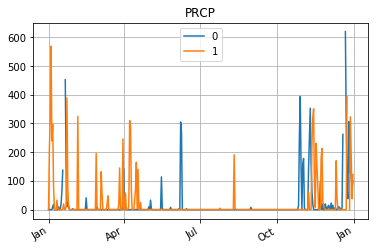

In [10]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

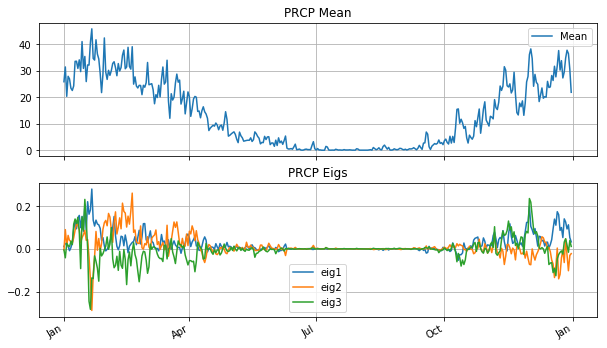

In [11]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

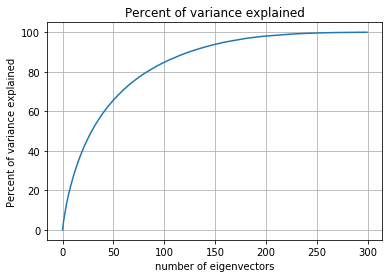

In [33]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:300]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [13]:
# s = np.array(EigVec[:,0]).flatten() #flattens the array (365,1) to (366,)
# s.shape
# v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
# len(v[1])


# Eigen_decomp(self,x,f,mean,v) in lib/Eigen_decomp.py

#         :param x: defines the x locations
#         :param f: the function to be approximated
#         :param mean: The initial approximation (the mean)
#         :param v: a list of numpy.arrays that are the eigenvectors
#         :returns: None
                
# eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
# T[i] = T[2] 3rd row from T -> PRCP|USC00047880 data from 1949

In [14]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
print "i",i, T[i].shape, len(v), Mean.shape
eigen_decomp=Eigen_decomp(None,T[273],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

print reductions
per=reductions[1]
print 'percentage explained by mean:',per[0]
print 'percentage explained after mean + top eigs:',per[1:]

i 2 (365,) 3 (365,)
residual normalized norm  after mean: 0.831398637775
residual normalized norm  after mean + top eigs: [ 0.82270609  0.72459834  0.50864108]
('reduction in var for mean,eig1,eig2,...', array([  1.68601362e-01,  -8.02693245e+03,  -4.44180093e+03,
        -9.77740515e+03]))
percentage explained by mean: 0.168601362225
percentage explained after mean + top eigs: [-8026.9324475  -4441.80092524 -9777.40515216]


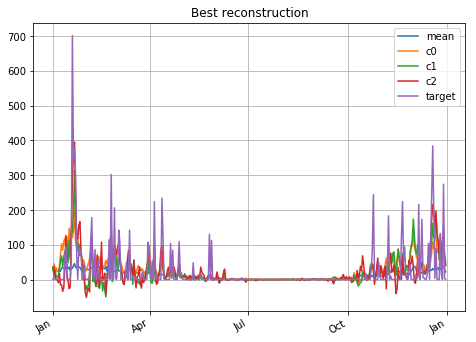

In [15]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [16]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [17]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.890753092348 res_1 : 0.999991926948 res_2 : 0.987245063838 res_3 : 0.981976900977
res_mean : 0.876333552231 res_1 : 0.999975145496 res_2 : 0.998254455124 res_3 : 0.998045365715
res_mean : 0.905202031682 res_1 : 0.999813942834 res_2 : 0.999777199358 res_3 : 0.973007961288


In [18]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2739
after filter 2369


In [19]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [20]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [21]:
df4=df3.filter(df3.res_2>1).sort(df3.coeff_2)
print df4.count()
df4.select('coeff_1','res_1','coeff_2','res_2').show()

11
+-------------------+------------------+-------------------+------------------+
|            coeff_1|             res_1|            coeff_2|             res_2|
+-------------------+------------------+-------------------+------------------+
|-60.164152283110276|1.0054488589599413| -66.89500722961449|1.0120541858129286|
|-132.06026701709195|1.0064552698170584| -54.08954165350816|1.0031906040757734|
|-138.16946695810742|0.9940725165137526| -36.26803215070807|1.0002182348769568|
| -76.69668219800278|1.0088608044812957|-33.497369552543596|1.0082593456030984|
|  -117.078167989766|1.0118439673990358| -32.29289956880106|1.0111225898062965|
|-103.74325391659254| 1.000828942273457|-15.658988050953756|1.0003193257876204|
|-13.775682522725457|1.0009065550478424|-0.7690134351860234|1.0010417871770698|
| -8.119096906820678| 1.000726409270089|  13.25772398044204|1.0003277899798582|
|-19.180881195555745| 1.000230470839579|  21.96667199348829| 1.000360075645557|
| -76.58310075095814|1.00737977893259

In [22]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(20)
df3.select('coeff_1','coeff_2','coeff_3', 'station').show(10)
df3.select('elevation','latitude','longitude', 'station','year').show(20)


+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
| 0.831398637775084|0.8227060904604301|0.7245983442470315|0.5086410783904033|
|0.8229416320015863|0.8886006210523046|0.7139825509278143|0.5209318165331804|
|0.8739383887775783|0.7164806026946848| 0.681260279225267| 0.525865042230603|
|0.8259947834459402| 0.867782999943917|0.7263925902304007|0.5352559985656099|
|0.8338313557106002|0.8706173316192607|0.7269800709298071|0.5392482881602143|
|0.8301866643236889|0.8820850730939191|0.7300444936977364|0.5415705897501647|
|0.8545770420141814|0.7398495800426461| 0.724671941896018|0.5421660787935333|
|0.8492065055439754|0.8035482169008309| 0.800377805507663|0.5426432681860803|
|0.8556776905523773|0.7655862316919894|0.7031070668928774|0.5460311649453764|
|0.8115520352700879|0.8854388166629422|0.7083666402241727| 0.552

/Users/skenchar/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


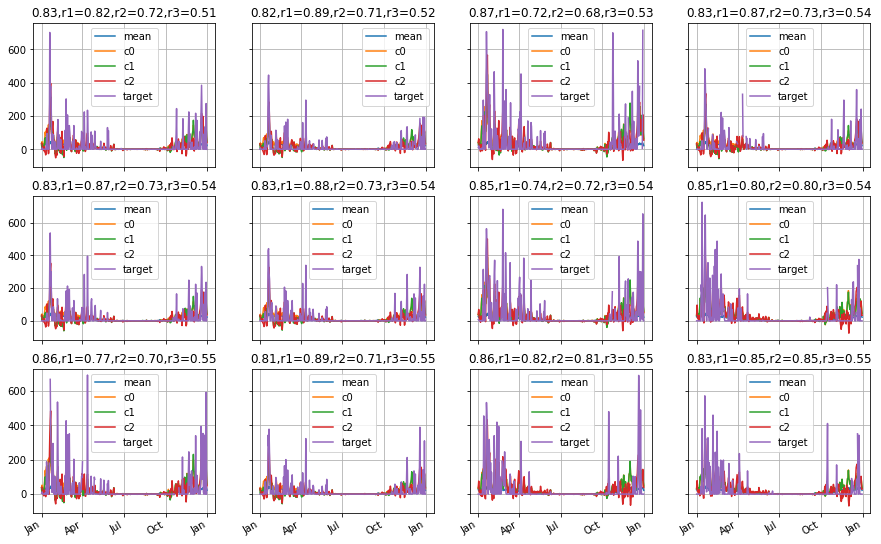

In [23]:
plot_recon_grid(rows)

In [24]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(20)
df3.select('coeff_1','coeff_2','coeff_3', 'station').show(10)
df3.select('elevation','latitude','longitude', 'station','year').show(20)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8535704870501266|1.0054488589599413|1.0120541858129286|1.0121404851840106|
|0.8078879690551253|1.0118439673990358|1.0111225898062965|1.0085645106390582|
|0.8526745180381472|1.0064552698170584|1.0031906040757734|1.0032048407153462|
|0.8634017188375548|1.0088608044812957|1.0082593456030984|  1.00233882974009|
|0.8392265022749436|0.9940725165137526|1.0002182348769568|1.0004741288423222|
| 0.912316148905055|1.0000100294674625|0.9999535270964142|0.9997082047396004|
|0.8871574521334742|0.9996454884120755|0.9996674944495354|0.9996479105667128|
|0.8937211689395931|0.9998921871456139|0.9997722164981919|0.9993782030600373|
|0.8979846752446722|1.0001263862768446|0.9996521979311693|0.9993476155157671|
|0.8819563914085895|0.9998613071950088|0.9995606636387799|0.9993

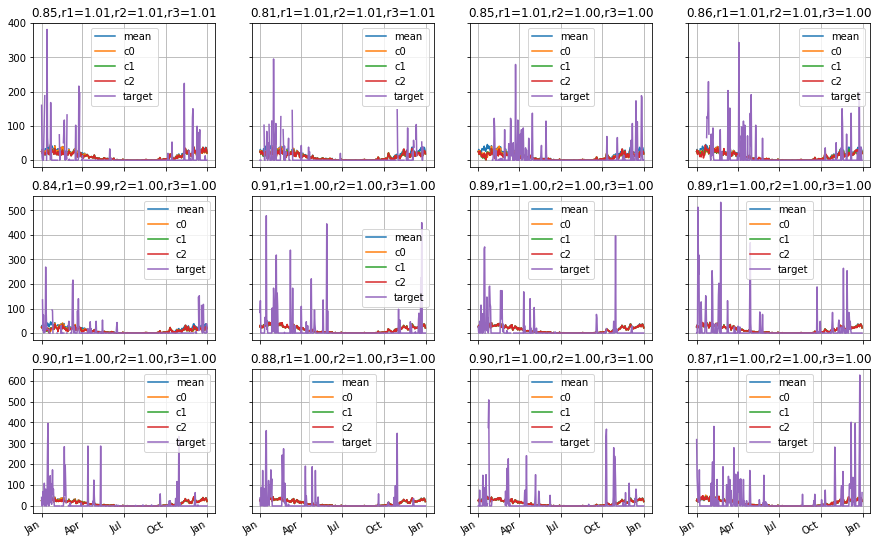

In [25]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

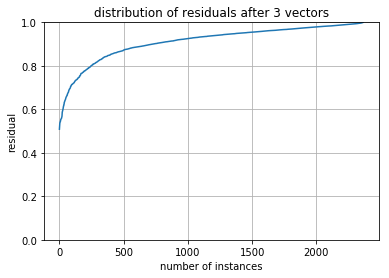

In [26]:
df3=df3.sort(df3.res_3,ascending=True)
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [27]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    print 'val:', len(vals)
    print max(vals)
    print min(vals)
    P=np.arange(0,(1+1./(len(vals))),1./(len(vals)))
    #P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    print 'val:', len(vals)
    print P.shape


    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

val: 2369
1.01214048518
0.50864107839
val: 2370
(2370,)


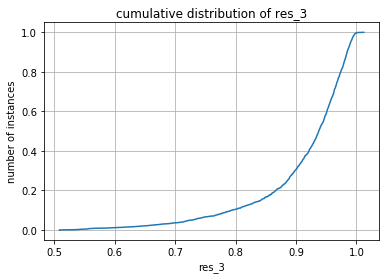

In [28]:
plot_CDF('res_3')

In [29]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [30]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.1M	../../Data/Weather/US_Weather_SSSBSSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_PRCP.parquet
216K	../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_TOBS.parquet


In [31]:

from ipywidgets import *
from IPython.display import display
w = IntSlider()
display(w, w)